In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
from assemble import DataStream, DataDescribe
import warnings
import json
warnings.filterwarnings('ignore')

# OverView
This notebook will explore the training and test dataset and clean and transform the data for the machine learning purpose. It consists of several sections as following:
* Data Loading
* Data General Summary
* Individual Feature Exploration
* Pairwise Feature Exploration
* Missing Values handling
* Feature Constructions

# Data Loading
The training and test data is loaded using the paths specified in JSON file. A general assumption for the machine learning is that the training and test data are all [independent and identically distributed (_i.i.d._)](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) from the same probability distribution. Therefore, one can __combine the training data and test data__ for the data transformation as `all` data and do the feature engineering as a whole data.

In [2]:
train,test= DataStream.load_data("data.json")

# Training Data Explore
Now let's explore the training data by showing the size of the data, number of missing data, and others. 

In [3]:
Train_explore = DataDescribe(train)
Train_explore.summary()

The number of observations and the number of features are in (rows, columns) format:  (1460, 81)
General summary for each feature in the data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null in

There are 80 features in the data, including the `Id`. Now the features that have missing values can be found here:

The features below have missing values:
['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'MasVnrType', 'Electrical']
Axes(0.125,0.125;0.775x0.775)


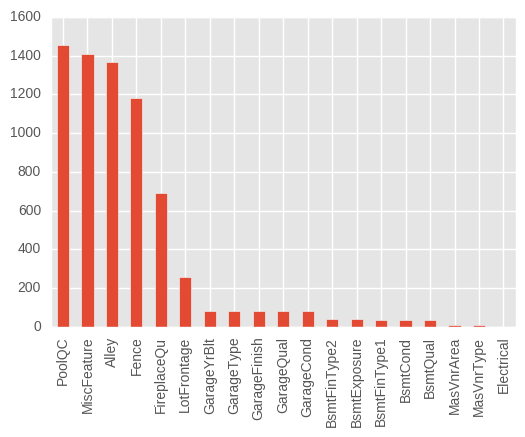

In [4]:
Train_explore.find_empty()

There are several features that most of values are missing, `PoolQC`, `MiscFeature`, `Alley`, `Fence`.

From [the original paper](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) for this data, there are several points in the training can be considered as outliers that can be exluded. Those are "House with more than 4000 square feet" that can be removed from the training.

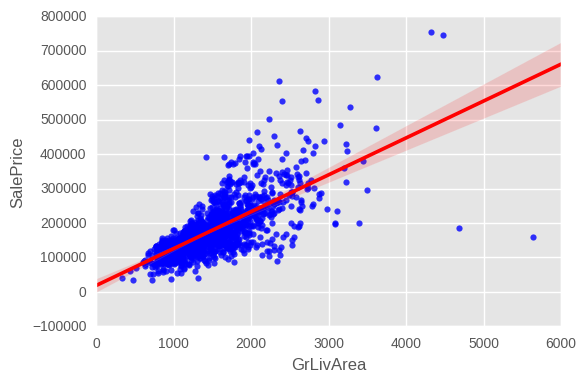

In [5]:
sns.regplot(x = "GrLivArea", y = "SalePrice", data = train, color= "red", scatter_kws={"color": "blue"})

In [6]:
train = train[train.GrLivArea < 4000]

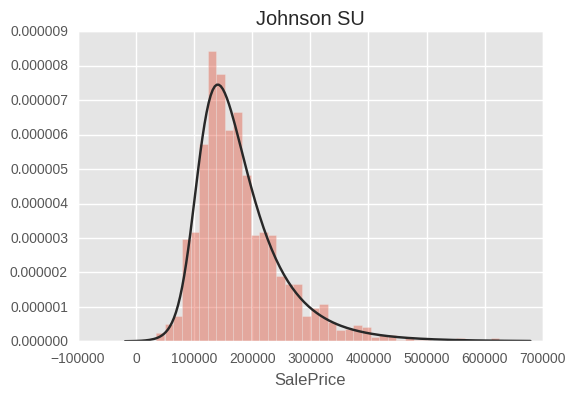

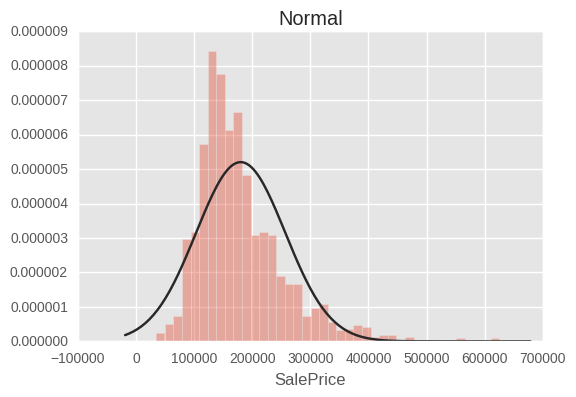

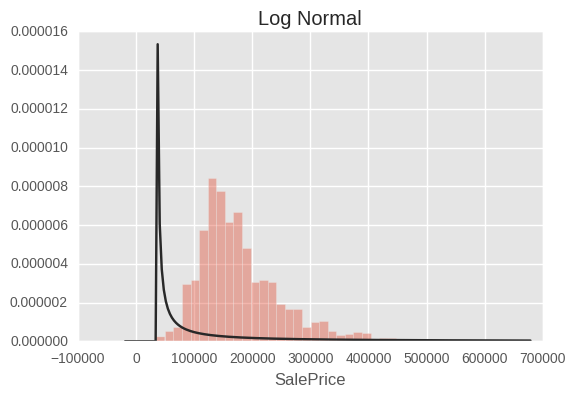

In [7]:
y = train["SalePrice"]
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

The SalePrice is not from a Normal distribution, which can use Shapiro-Wilk test for its normality. 

In [8]:
st.shapiro(y)[1] < 0.01

True

Excluding the columns as following: ['Id', 'SalePrice']
The numerical features are ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
The categorical features are: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',

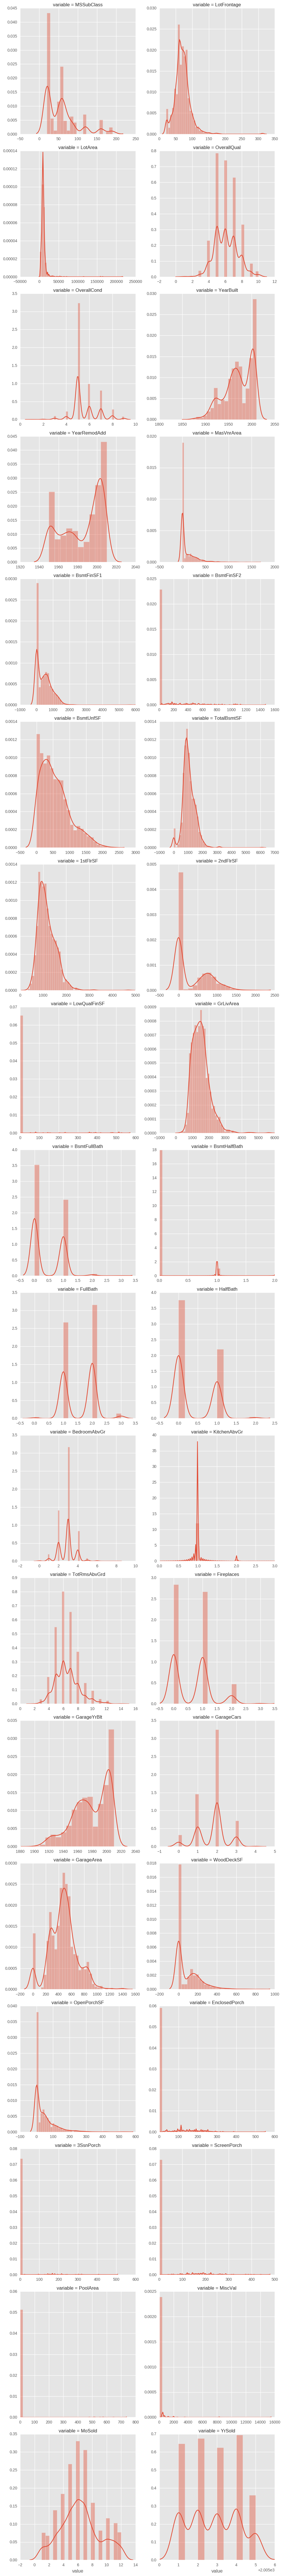

In [9]:
Train_explore.show_numerical(["Id", "SalePrice"])

From the numerical features, there are several features one can use logorithm to normalize the distribution. 

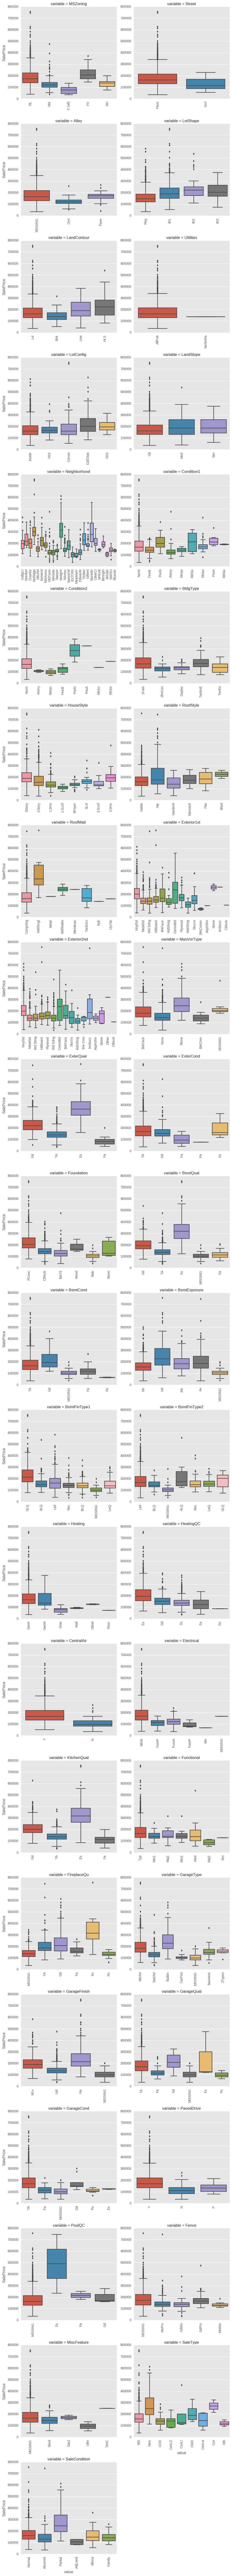

In [10]:
Train_explore.show_category(exclude=["Id", "SalePrice"], response="SalePrice")

To better illustrate the influence of the categorical variables on the target values, we can do one way ANOVA test on the feature and compute the p-value of the result. Here we shows the inverse of the p-value for all categorical features.

Here is a quick estimation of influence of categorical variables on SalePrice


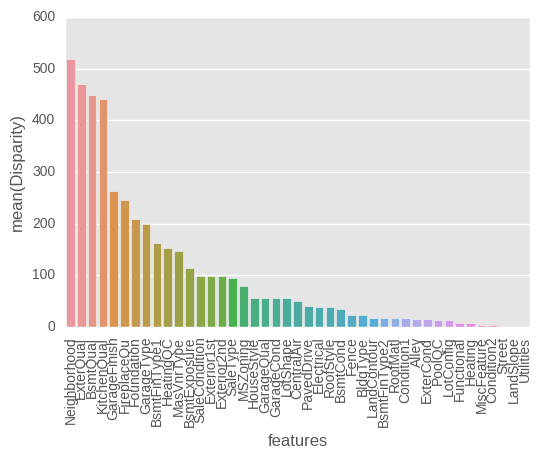

In [11]:
Train_explore.show_influence(exclude=["Id", "SalePrice"], response="SalePrice")

In [12]:
all = DataStream.union_datasets(train, test)

A new DataFrame is generated combining training and test data...
The common columns are: 
['MiscFeature', '2ndFlrSF', 'BsmtFinType2', 'GarageQual', 'GarageType', 'OpenPorchSF', 'Functional', 'BsmtFinType1', 'Exterior2nd', 'RoofStyle', 'EnclosedPorch', 'MasVnrType', 'LotFrontage', 'MiscVal', 'PoolArea', 'GarageFinish', 'OverallCond', 'LandSlope', 'BsmtUnfSF', 'YrSold', 'LotConfig', 'BsmtHalfBath', 'FireplaceQu', 'MSZoning', 'Fireplaces', '3SsnPorch', 'LotShape', 'SaleCondition', 'ScreenPorch', 'ExterCond', 'PavedDrive', 'ExterQual', 'GrLivArea', 'BldgType', 'HouseStyle', 'Utilities', 'YearBuilt', 'Condition1', 'Neighborhood', 'Street', 'HeatingQC', 'FullBath', 'SaleType', 'BsmtFinSF2', 'KitchenAbvGr', 'YearRemodAdd', 'LandContour', 'BsmtFinSF1', '1stFlrSF', 'RoofMatl', 'TotRmsAbvGrd', 'Alley', 'Heating', 'WoodDeckSF', 'Foundation', 'Electrical', 'Fence', 'GarageArea', 'Id', 'LowQualFinSF', 'BsmtCond', 'GarageCars', 'OverallQual', 'GarageYrBlt', 'BsmtFullBath', 'TotalBsmtSF', 'Condition2

In [13]:
from assemble import DataCleaner
data = DataCleaner(all)

From the data descriptions, there are many variables which have NaN that need to be considered as absence of the property.

In [14]:
fill_dict = {"NoBsmt": ["BsmtFinType1", "BsmtCond", "BsmtFinType2", "BsmtExposure", "BsmtQual"],
             "NoGarage": ["GarageCond", "GarageQual", "GarageFinish", "GarageType"],
             "NoPool": ["PoolQC"],
             "NoFirePlace": ["FireplaceQu"],
             "NoFence":["Fence"],
             "NoAccess": ["Alley"],
             "None": ["MiscFeature", "MasVnrType"]
             }
data.fill_na_spec(fill_dict)

Column MiscFeature 's empty value has been replaced by None
Column MasVnrType 's empty value has been replaced by None
Column BsmtFinType1 's empty value has been replaced by NoBsmt
Column BsmtCond 's empty value has been replaced by NoBsmt
Column BsmtFinType2 's empty value has been replaced by NoBsmt
Column BsmtExposure 's empty value has been replaced by NoBsmt
Column BsmtQual 's empty value has been replaced by NoBsmt
Column PoolQC 's empty value has been replaced by NoPool
Column FireplaceQu 's empty value has been replaced by NoFirePlace
Column Fence 's empty value has been replaced by NoFence
Column Alley 's empty value has been replaced by NoAccess
Column GarageCond 's empty value has been replaced by NoGarage
Column GarageQual 's empty value has been replaced by NoGarage
Column GarageFinish 's empty value has been replaced by NoGarage
Column GarageType 's empty value has been replaced by NoGarage

 Now the columns have been updated:
['MiscFeature', 'MasVnrType', 'BsmtFinType1'

In the variables related to garage, there is one empty value in `GarageArea` and `GarageCars` when it has the `GarageType = Detchd`. So one can impute the missing value with the median value of the `GarateArea` when `GarageType = Detchd`. 

In [15]:
print ("The GarageType is " + data.all_data.loc[data.all_data.GarageArea.isnull(),'GarageType'] + 
       ", when the Garage Area is empty")
group = {("GarageType", "Detchd"): ["GarageArea", "GarageCars"] }
data.fill_na_group(group)

2572    The GarageType is Detchd, when the Garage Area...
Name: GarageType, dtype: object
Now column GarageArea 's empty value has been replaced by 399.5
Now column GarageCars 's empty value has been replaced by 2.0

 Now the columns have been updated:
['GarageArea', 'GarageCars']
Now the column name(s) that have empty values are:
LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
MSZoning          4
Utilities         2
BsmtHalfBath      2
Functional        2
BsmtFullBath      2
BsmtFinSF1        1
Exterior1st       1
SaleType          1
Electrical        1
TotalBsmtSF       1
BsmtUnfSF         1
KitchenQual       1
Exterior2nd       1
BsmtFinSF2        1
dtype: int64


For Basement areas, if there is no basement, the area should be zero. Similar issues apply Masonry veneer area, Garage area, Pool area, Fireplaces

In [16]:
value_matching = {
    ("NoBsmt", 0): [("BsmtFinType1", "BsmtFinSF1"), ("BsmtFinType2", "BsmtFinSF2"), ("BsmtQual", "TotalBsmtSF"),
                    ("BsmtQual", "BsmtUnfSF")
                    ],
    ("None", 0):[("MasVnrType","MasVnrArea")],
    ("NoGarage", 0) : [("GarageType", "GarageCars"), ("GarageType", "GarageArea")],
    ("NoPool", 0): [("PoolQC", "PoolArea")],
    ("NoFirePlace", 0): [("FireplaceQu", "Fireplaces")]
}
mapping = {("None", 0): [("MiscFeature", "MiscVal")]}
data.convert_value(value_matching)
data.convert_value(mapping, True)


 Now the columns have been updated:
['PoolArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF', 'MasVnrArea', 'Fireplaces', 'GarageCars', 'GarageArea']

 Now the columns have been updated:
['MiscVal']


In [17]:
# Now one can impute the missing variables with most common values
data.fill_na_gen()

Now the column name(s) that have empty values are:
LotFrontage     486
GarageYrBlt     159
MSZoning          4
BsmtFullBath      2
Utilities         2
BsmtHalfBath      2
Functional        2
Exterior1st       1
KitchenQual       1
Electrical        1
SaleType          1
Exterior2nd       1
dtype: int64
Now column LotFrontage 's empty value has been replaced by 68.0
Now column GarageYrBlt 's empty value has been replaced by 1979.0
Now column MSZoning 's empty value has been replaced by RL
Now column BsmtFullBath 's empty value has been replaced by 0.0
Now column Utilities 's empty value has been replaced by AllPub
Now column BsmtHalfBath 's empty value has been replaced by 0.0
Now column Functional 's empty value has been replaced by Typ
Now column Exterior1st 's empty value has been replaced by VinylSd
Now column KitchenQual 's empty value has been replaced by TA
Now column Electrical 's empty value has been replaced by SBrkr
Now column SaleType 's empty value has been replaced by WD
N

There are two features which are not numerical features: `MSSubClass` and `MoSold`.

In [18]:
interpret_mapping = {
    'MSSubClass': { 20: "SubClass_20",
                     30: "SubClass_30",
                     40: "SubClass_40",
                     45: "SubClass_45",
                     50: "SubClass_50",
                     60: "SubClass_60",
                     70: "SubClass_70",
                     75: "SubClass_75",
                     80: "SubClass_80",
                     85: "SubClass_85",
                     90: "SubClass_90",
                     120: "SubClass_120",
                     150: "SubClass_150",
                     160: "SubClass_160",
                     180: "SubClass_180",
                     190: "SubClass_190"},
    'MoSold': { 1:"Jan",
                2:"Feb",
                3:"Mar",
                4:"Apr",
                5:"May",
                6:"Jun",
                7: "Jul",
                8: "Aug",
                9:"Sep",
               10:"Oct",
               11:"Nov",
               12:"Dec"}
    }
data.interpret_value(interpret_mapping)

For categorical features, we will calculate the average of `SalePrice` for each group, sort the value in the ascending order and encode those order position. 

In [19]:
from assemble import Category
data = Category(data.all_data)

In [20]:
train.replace(interpret_mapping,inplace=True)

In [21]:
data.transform(train, "SalePrice", True)

In [22]:
all = data.data

In [23]:
encoded = data.encoded

In [24]:
numerical = [f for f in all.columns if all.dtypes[f] != "object"]

Let's look at the correlation heatmap.

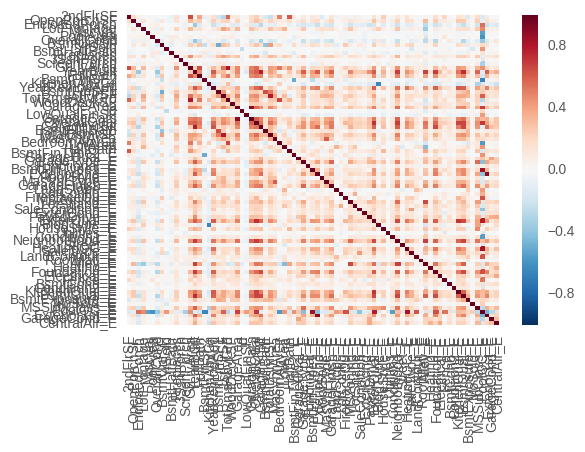

In [25]:
sns.heatmap(all[numerical].corr())

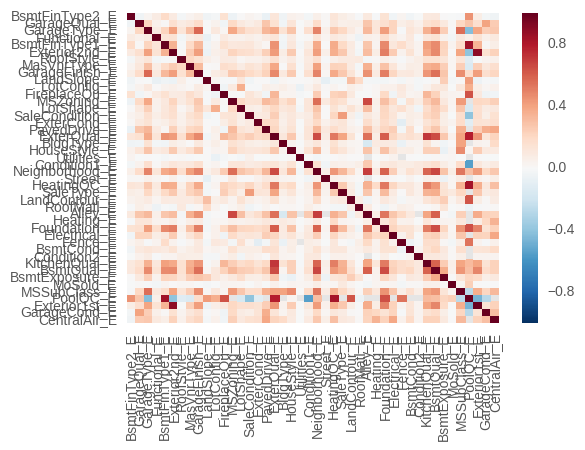

In [26]:
sns.heatmap(all[encoded].corr())

From the definition of each feature in the description, one may create some new features by 
* adding several features together as a new feature
* multiple features to create a new one

In [27]:
all["FlrSF"] = all["1stFlrSF"] + all["2ndFlrSF"]
all["totalArea"] = all["GrLivArea"] + all["TotalBsmtSF"]
all["totalBedRooms"] = all["FullBath"] + 0.5 * all["HalfBath"] + all["BsmtFullBath"] + 0.5 * all["BsmtHalfBath"]
all["PorchSF"] = all["OpenPorchSF"] + all["EnclosedPorch"] + all["3SsnPorch"] + all["ScreenPorch"]
all["totalRms"] = all["TotRmsAbvGrd"] + all["FullBath"] + 0.5 * all["HalfBath"]

In [28]:
all["OverallScore"] = all["OverallQual"] * all["OverallCond"]
all["ExterScore"] = all["ExterQual_E"] * all["ExterCond_E"]
all["KitchenScore"] = all["KitchenAbvGr"] * all["KitchenQual_E"]
all["FireplaceScore"] = all["Fireplaces"] * all["FireplaceQu_E"]
all["GarageScore"] = all["GarageQual_E"] * all["GarageCond_E"]
all["GarageGrade"] = all["GarageArea"] * all["GarageQual_E"]
all["PoolScore"] = all["PoolArea"] * all["PoolQC_E"]

In [29]:
generated = ["FlrSF", "totalArea", "totalBedRooms", "PorchSF", "totalRms","OverallScore","ExterScore","KitchenScore","FireplaceScore","GarageScore","GarageGrade", "PoolScore" ]

In [30]:
features = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'LotArea', 'LotFrontage', 'KitchenAbvGr','GarageArea']
for f in features:
    all[f] = np.log1p(all[f].values)

In [31]:
all_features = numerical + encoded + generated

In [32]:
all_features.remove("Id")

In [33]:
all_values = all[all_features]

In [34]:
all_values.fillna(0,inplace=True)

In [35]:
X_train, X_test, y = DataStream.prepare_for_learn(train, all_values, "SalePrice")

In [36]:
print(X_train.shape)
print(X_test.shape)
print(y.shape)

(1456, 134)
(1459, 134)
(1456,)


In [37]:
y = np.log1p(y)

In [38]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

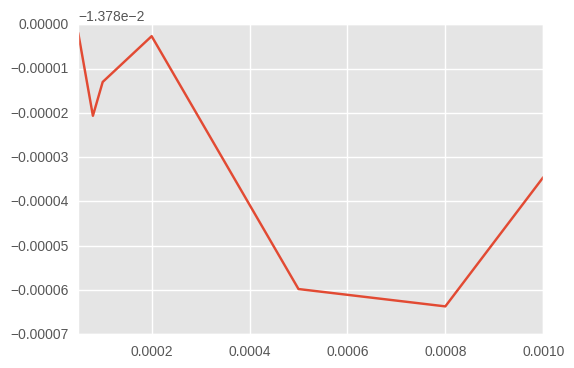

In [39]:
from sklearn.linear_model import Lasso
alphas = [5e-5, 8e-5, 1e-4,2e-4,  5e-4,8e-4, 1e-3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [45]:
model = Lasso(alpha = 2e-4, max_iter =  50000).fit(X_train, y)

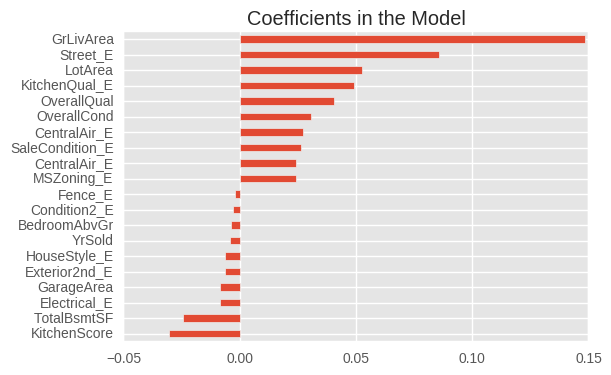

In [46]:
coef = pd.Series(model.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

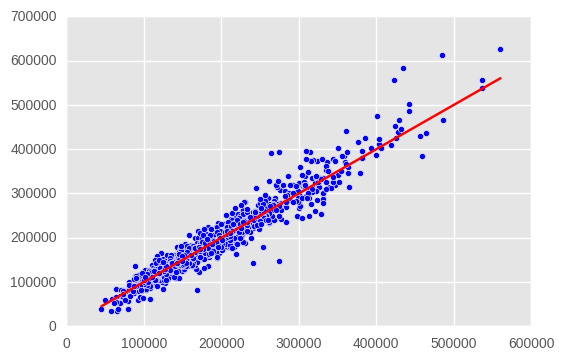

In [47]:
p_pred = np.expm1(model.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

In [48]:
# save to file to make a submission
p = np.expm1(model.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("test-2-19.csv", index = False)

In [49]:
import json
with open("data.json") as json_file:
    json_decode = json.load(json_file)

json_decode["2-19Update"] = "submission-2-19.p"

with open("data.json", "w") as json_file:
    json.dump(json_decode, json_file)